# solomon insertation (i)

In [1]:
import numpy as np
import pandas as pd
import time
import math
import random

In [2]:
print(time.ctime())

Fri Jan  6 18:11:40 2023


In [3]:
class Node:
    def __init__(self, index, lat, long, demand,begin_time,end_time,serv_time):
        self.index = index
        self.demand = demand
        self.serv_time = serv_time
        self.begin_time = begin_time
        self.end_time = end_time
        self.lat = lat
        self.long = long
        self.route = 99

    def __index__(self):
        return self.index

    def __hash__(self):
        return self.index

    def __repr__(self):
        return f"Customer <{self.index}>"

In [4]:
class RouteType:
    def __init__(self):
        self.load = 0  # 单条路径载重
        self.sub_t = 0  # 单条路径违反各节点时间窗约束时长总和
        self.dis = 0  # 单条路径总长度
        self.v = []  # 单条路径顾客节点序列

In [5]:
def calDistance(Customer):
    ''' 
    计算城市间距离
    输入：CityCoordinates-城市坐标；
    输出：城市间距离矩阵-dis_matrix
    '''
    t =len(Customer)
    dis_matrix = np.zeros([t,t])
    for i in range(t):
        xi,yi = Customer[i].lat,Customer[i].long
        for j in range(t):
            xj,yj = Customer[j].lat,Customer[j].long
            dis_matrix[i,j] = round(math.sqrt((xi-xj)**2+(yi-yj)**2),2)
    return dis_matrix

In [6]:
# 计算每个点开始服务的时间
def begin_time(nodes,line): # 
    b = np.zeros(len(nodes)) 
    for i in range(len(line)):
        client = int(line[i])
        if i == 0: # 最后b[0] 是回到depot的时间
            continue
        else:
            # 考虑开始时间
            p_client = int(line[i-1]) # 上一个customer
            b[client]=max(b[p_client]+ dis_matrix[p_client,client]+nodes[p_client].serv_time,nodes[client].begin_time)
            # 不考虑开始时间
#             b[client]=b[client-1]+ dis_matrix[client-1,client]+nodes[client].serv_time
    return b

In [7]:
# 车辆初始化函数 criteria 1 选距离最远的客户
def first_customer(depot_dis):
    customer_new = np.argmax(depot_dis) 
#     t_min = np.argmin(endtime) 
    return customer_new

In [8]:
# 车辆初始化函数 criteria 2 # 结束时间最早的客户
def first_customer_urgence(nodes):
    unrouted_c = list(range(len(nodes)))
    for i in range(len(nodes)):
        if nodes[i].route != 99:
            unrouted_c.remove(i)
    customer_new = np.argmin(endtime) 
    return customer_new

In [9]:
# 车辆更新逻辑
def update_line(car,line,d,nodes,capacity): # 车辆，初始路径，初始重量，客户
    a1,a2=0.5,0.5
    c_2 = np.zeros(len(nodes))
    next_lines = {}

    for u in range(1,len(nodes)) : #每个客户 去掉0:depot  
        if (nodes[u].route == 99) and (nodes[u].demand + d <= capacity): 
            # 如果客户没有分配 且# 当前路径总重量+客户重量<=capacity 
            route = []
            c_11 = np.zeros(len(line)-1)
            c_12 = np.zeros(len(line)-1)
            c_1 = np.zeros(len(line)-1)
            b0 = begin_time(nodes,line)
            for i in range(len(line)-1): # 算每个客户插到当前路径不同位置的c1
                # 把u插入line[i]和line[i+1]之间
                l = list(line)
                l.insert(i+1,u)
                b1 = begin_time(nodes,l)
                if all(b1 <= endtime): # 满足结束时间 (b < 结束时间矩阵) 才把路径加入备选项
                    c_11[i] = dis_matrix[line[i]][u]+dis_matrix[u][line[i+1]]-dis_matrix[line[i]][line[i+1]]
                    c_12[i] = b1[i+1]-b0[i+1]
                    c_1[i] = a1*c_11[i]+a2*c_12[i]
                else:
                    c_1[i] = 10000
                route.append(tuple(l))
            if route: # 如果route不是空list，选c1最小的路径，求每个customer的c2
                Broute = route[np.argmin(c_1)] # best route for u 
                next_lines[u]=Broute
                c_2[u] =dis_matrix[0][u] -min(c_1)
    if (next_lines) and (max(c_2) > 0): 
        next_line = next_lines[np.argmax(c_2)] # 如果不为空更新路线
        for i in next_line:
            depot_dis[i] = 0 # 这个一直记录 把所有分配过的点都改成0 
            nodes[i].route = car  # 改变车的路径
        d += nodes[np.argmax(c_2)].demand
    else :
        next_line = line 
    return next_line,d

In [10]:
# 读取数据
import re
with open('c101.txt', 'r') as f: 
    # Read all the lines of the file into a list 
    lines = f.readlines() 
    
    params = re.findall('[0-9]+',lines[4]) # 车辆数和capacity
    vehicleNumber = int(params[0])
    capacity = int(params[1])
    # Skip the first 9 line 
    lines = lines[9:] 
 
    # Iterate over the remaining lines 
    nodes= []
    for line in lines: 
        elements = re.findall('[0-9]+',line)
        nodes.append(Node(int(elements[0]), int(elements[1]),int(elements[2]),int(elements[3]), int(elements[4]),int(elements[5]),int(elements[6])))
# 车辆数和capacity

In [11]:
# 先从25个客户开始 第一个是depot
sub_nodes = nodes[:26]

In [12]:
# 结束时间
endtime = np.zeros(26)
for i in range(26):
    endtime[i] = sub_nodes[i].end_time
endtime

array([1236.,  967.,  870.,  146.,  782.,   67.,  702.,  225.,  324.,
        605.,  410.,  505.,  721.,   92.,  620.,  429.,  528.,  148.,
        254.,  345.,   73.,  965.,  883.,  777.,  144.,  224.])

In [13]:
# 距离矩阵
dis_matrix = calDistance(sub_nodes)

In [14]:
# depot到各个customer的时间 初始化
depot_dis = dis_matrix[0].copy()
depot_dis

array([ 0.  , 18.68, 20.62, 16.12, 18.11, 15.13, 19.  , 16.  , 18.11,
       20.1 , 16.76, 19.65, 38.08, 30.81, 39.36, 36.06, 40.31, 33.3 ,
       35.36, 39.05, 10.  , 10.2 , 12.17, 13.  , 15.  , 15.13])

In [15]:
# 初始化路径
import copy

routes = []
for i in range(vehicleNumber):
    # 给每一条路径赋初始起点与虚拟终点
    routes.append(RouteType())
    routes[i].v.append(copy.deepcopy(nodes[0]))
    routes[i].v.append(copy.deepcopy(nodes[0]))
#     routes[i].v[0].end = routes[i].v[0].begin
#     routes[i].v[1].begin = routes[i].v[1].end
    # 算例中给出节点0有起始时间0和终止时间，所以如上赋值。
    routes[i].load = 0

In [16]:
# 主代码
car=0  
i = 0
while i < 25 : #  客户没有分配 max(i.route for i in sub_nodes) == 99 #np.sum(depot_dis) > 0 
#     print(i,routes[car].load)
    if routes[car].load  > 0 :
        old_len = len(line)
        line,d= update_line(car=car,line=line,d=d,nodes=sub_nodes,capacity=capacity)
        new_len = len(line)
        routes[car].load = d
        routes[car].v = []
        for c in line : 
            routes[car].v.append(nodes[c])
        if d >= 200 :
            # 清空一下路径
            car +=1 # 一辆车结束后 车号更新
        elif old_len == new_len:
            car +=1 # 一辆车结束后 车号更新
            initial_c = first_customer(depot_dis)
            routes[car].v.insert(1,sub_nodes[initial_c]) # 在中间插入选中的客户
            depot_dis[initial_c]=0 # 把客户的距离改成0 初始时不会在选到这个客户
            line=[]
            for c in routes[car].v:
                c.route = car  # 改变车的路径
                line.append(c.index) # 改一下初始路径的格式
            d = sub_nodes[initial_c].demand #初始路径demand
            routes[car].load = d 
    else :
#         print("新车")
        initial_c = first_customer(depot_dis)
        routes[car].v.insert(1,sub_nodes[initial_c]) # 在中间插入选中的客户
        depot_dis[initial_c]=0 # 把客户的距离改成0 初始时不会在选到这个客户
        line=[]
        for c in routes[car].v:
            c.route = car  # 改变车的路径
            line.append(c.index) # 改一下初始路径的格式
        d = sub_nodes[initial_c].demand #初始路径demand
        routes[car].load = d 
    i +=1
#     print(car)
#     print(line)
#     print(depot_dis)

# 结果

In [17]:
car_n = 0
for i in range(20):
    if routes[i].load > 0:
        car_n += 1
        print(i,routes[i].load)
        print(routes[i].v)
print("-"*50)
print('Car used ：',car_n)

0 200
[Customer <0>, Customer <13>, Customer <17>, Customer <18>, Customer <19>, Customer <15>, Customer <16>, Customer <14>, Customer <12>, Customer <1>, Customer <0>]
1 170
[Customer <0>, Customer <5>, Customer <3>, Customer <7>, Customer <8>, Customer <10>, Customer <11>, Customer <9>, Customer <6>, Customer <4>, Customer <2>, Customer <21>, Customer <0>]
2 90
[Customer <0>, Customer <20>, Customer <24>, Customer <25>, Customer <23>, Customer <22>, Customer <0>]
--------------------------------------------------
Car used ： 3


In [18]:
# 计算距离
distance = 0 
d_mat = np.zeros([4,15])
b = {}
for i in range(4):
    line=[]
    for c in routes[i].v:
        line.append(c.index) 
    b[i] = begin_time(sub_nodes,line)
#     print(b[i])
    for j in range(len(routes[i].v)-1):
        ci = routes[i].v[j].index
        cj = routes[i].v[j+1].index
        distance += dis_matrix[ci,cj]
        d_mat[i,j] = dis_matrix[ci,cj]
#         print(ci,cj,dis_matrix[ci,cj])
print('Total distance :',distance)

Total distance : 211.60000000000002


In [19]:
# 检查是否都在结束时间内送到了
b_r = pd.DataFrame(b)
b_ = b_r.max(axis=1).to_numpy()
b_<= endtime

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [20]:
import matplotlib.pyplot as plt
def draw_path(routes: RouteType):
    # calculate number of routes in current solution
    route_num = 0
    for i in range(vehicleNumber):
        if len(routes[i].v) != 2:
            route_num += 1
            
    for i in range(route_num):
        x, y = [],[]
        for j in range(len(routes[i].v)):
            x.append(routes[i].v[j].lat)
            y.append(routes[i].v[j].long)
        plt.plot(x, y,'o-', alpha=0.8, linewidth=0.8)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

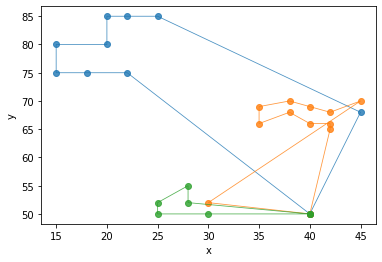

In [21]:
draw_path(routes)

In [22]:
# 检查是否每个用户都送了
for i in range(len(sub_nodes)):
    print(sub_nodes[i].route,end=" ")

2 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 2 1 2 2 2 2 

In [23]:
print(time.ctime())

Fri Jan  6 18:11:43 2023
